The first tutorial of this series showed how an RC model could represent the thermal behaviour of a small test box, and be used to identify its properties: thermal resistance and capacity.

In more realistic applications, the phenomena that impact the energy balance of a building are far more complex than what such a simple model may predict. We extend the RC model structure in order to include effects of solar irradiance, ventilation, several time constants of inertia... But there is a limit to how complex a model can be made, before parameter identification becomes infeasible.

If a model does not fully describe the thermal behaviour of the building, and this discrepancy is not somehow explicitely accounted for, then the parameter estimates and predictions will be biased and unreliable. Stochastic state-space models are a way to account for modelling uncertainties and are now standard practice in the field of building energy performance assessment.

This notebook shows a simple implementation of a state-space model and a Kalman filter, which can be used for parameter estimation and prediction. The reader can see this paper, among many others, for more information on the theory:

[*Rouchier, S., Rabouille, M., & Oberlé, P. (2018). Calibration of simplified building energy models for parameter estimation and forecasting: Stochastic versus deterministic modelling. Building and Environment, 134, 181-190.*](https://hal.archives-ouvertes.fr/hal-01739625)

## Some theory of state-space models and the Kalman filter

### An example of state-space model

Consider the example of a simple building represented by a 2-resistor, 2-capacitor model structure (2R2C) 

<img src='figures/ssm02_2r2c.png' width=400 />

The equations of this model are:

\begin{align}
  C_i \, \mathrm{d} T_i & = \dfrac{1}{R_i}\left(T_e-T_i\right)\mathrm{d}t + \Phi \, \mathrm{d}t + A_i I_s \mathrm{d}t + \sigma_i \,\mathrm{d}\omega_i\label{eq:statespace1} \\
  C_e \, \mathrm{d} T_e & = \dfrac{1}{R_i}\left(T_i-T_e\right)\mathrm{d}t + \frac{1}{R_e}\left(T_a-T_e\right)\mathrm{d}t + A_e I_s \mathrm{d}t + \sigma_e \, \mathrm{d}\omega_e \label{eq:statespace2}
\end{align}

where $T_i$, $T_e$ and $T_a$ are the indoor, envelope and ambient (outdoor) temperatures. The envelope temperature is associated with the thermal mass of the opaque surfaces, and does not represent a specific coordinate within the envelope. The model has two states $T_e$ (unobserved) and $T_i$ (observed); $\Phi_h$ (W) is the indoor heating power; $I_s$ (W/m$^2$) is the global horizontal solar irradiance. $R_i$ (K/W) is the thermal resistance between the indoor air temperature and the envelope, $R_e$ the resistance between the envelope and the ambient air. $C_i$ and $C_e$ (J/K) are the heat capacities of the interior and the envelope, respectively, and $A_i$ and $A_e$ (m$^2$) are their solar gain coefficients. $\{\omega_i\}$ and $\{\omega_e\}$ are standard Wiener processes. $\sigma_i^2$ are $\sigma_e^2$ are their variances. This process noise is a way to account for modelling approximations, unrecognized inputs or noise-corrupted input measurements.


Despite its simplicity, this model structure is able to reproduce the thermal behaviour of a simple unoccupied building. The equations can be written in matrix form:
$$
\mathrm{d} \begin{bmatrix} T_i \\ T_e \end{bmatrix} = \begin{pmatrix} -\frac{1}{R_i \, C_i} & \frac{1}{R_i \, C_i} \\ \frac{1}{R_i \, C_e} & -\frac{1}{R_i \, C_e}-\frac{1}{R_e \, C_e}\end{pmatrix} \begin{bmatrix} T_i \\ T_e \end{bmatrix}\, \mathrm{d}t + \begin{pmatrix} 0 & \frac{1}{C_i} & \frac{k_1}{C_i} \\ \frac{1}{R_e \, C_e} & 0 & \frac{k_2}{C_e} \end{pmatrix} \begin{bmatrix} T_a \\ \Phi_h \\ I_s \end{bmatrix} \, \mathrm{d}t + \mathbf{\sigma} \, \mathrm{d}\omega $$

which is the state equation in the following stochastic state-space model, written in continuous-discrete form:

\begin{align}
\mathrm{d}\mathbf{x}(t) & = \mathbf{A}_\theta \, \mathbf{x}(t) \, \mathrm{d}t + \mathbf{B}_\theta \, \mathbf{u}(t)\,\mathrm{d}t + \mathbf{\sigma}_\theta \mathrm{d}\omega \label{eq:statespace4} \\
\mathbf{y}_t & = \mathbf{C}_\theta \, \mathbf{x}_t + \varepsilon_t \label{eq:statespace5}
\end{align}

A state-space model is a set of two equations: the first one, the state equation, results from the physical formulation of the system. Its matrices $\mathbf{A}_\theta$, $\mathbf{B}_\theta$ and $\mathbf{\sigma}_\theta$ are given the $\theta$ subscript to indicate that they depend on a parameter $\theta$, which is the set of unknown values to be estimated: resistances, capacities, solar gain factors and variances of the Wiener processes. The state vector $\mathbf{x}$ includes the temperatures $T_i$ and $T_e$ calculated by the model, and $\mathbf{u}=\left[T_a, \Phi_h, I_s\right]$ is the input vector including boundary conditions and excitations. The second equation is the observation equation. It indicates that the measured quantity $y_t$ may be different from the output of the state equation. In our case, the observed temperature is only the first component of the state vector, and is encumbered with some measurement error $\varepsilon_t$. In this equation, time is noted as a subscript to indicate that observations come in a discrete sequence.

### Discretisation

The stochastic model must be discretized in order to specify its evolution between discrete time coordinates. Let us denote the sample interval length $\Delta t$ and assume that the inputs $\mathbf{u}(t)$ are constant during each interval. The two above equations can be discretized into the following discrete linear system of equations:

\begin{align}
		\mathbf{x}_t & = \mathbf{F}_\theta \, \mathbf{x}_{t-1} + \mathbf{G}_\theta \, \mathbf{u}_t + \mathbf{w}_t \label{eq:linear_discrete_1} \\
		\mathbf{y}_t & = \mathbf{C}_\theta \, \mathbf{x}_t + \mathbf{v}_t \label{eq:linear_discrete_2}
\end{align}

where $\mathbf{x}_t$ denotes the vector of states at the time coordinate $t$, and $\mathbf{y}_t$ denotes the observations. The $\mathbf{F}_\theta$ and $\mathbf{G}_\theta$ matrices of the discrete equation result from the matrices of the continuous equation using the usual state-space discretization method. Their coefficients are functions of $\theta$ and of the time step size $\Delta t$. Similarly, the process noise in discrete time $\mathbf{w}_t \sim \mathcal{N}\left(0, \mathbf{Q}_d\right)$ has a covariance matrix $\mathbf{Q}_d$ that can be calculated from the covariance matrix of the process noise in continuous time $\mathbf{\sigma}$. The observation error $\mathbf{v}_t$ has a covariance $\mathbf{R}$, which depends on the variance of $\varepsilon_t$ and the time step size.

The discretization equations are given here, and are available with more detail in the literature:
$$
\begin{align}
  \mathbf{F}_\theta & = \mathrm{exp}\left( \mathbf{A}_\theta \, \Delta t  \right) \label{eq:discretization1}\\
  \mathbf{G}_\theta & = \mathbf{A}_\theta^{-1} \, \left(\mathbf{F}_\theta-\mathbf{I}\right) \, \mathbf{B}_\theta \label{eq:discretization2}\\
  \mathbf{Q} & = \int_0^{\Delta t} \mathrm{exp}\left( \mathbf{A}_\theta \, \Delta t  \right) \, \mathbf{\sigma} \, \mathrm{exp}\left( \mathbf{A}_\theta^T \, \Delta t  \right) \mathrm{d}t \label{eq:discretization4}\\
  \mathbf{R} & = \frac{1}{\Delta t} \mathrm{var}(\varepsilon_t) \label{eq:discretization5}
\end{align}
$$

### The Kalman filter equations

Given a state transition probability $p\left( \mathbf{x}_{t} | \theta, \mathbf{x}_{t-1}, \mathbf{u}_{t} \right)$ (the state equation) and an observation probability $p\left( \mathbf{y}_{t} | \mathbf{x}_{t}\right)$ (the observation equation), a Kalman filter produces $p\left(\mathbf{x}_t|\mathbf{y}_{1:T}, \theta \right)$, the probability distribution function of each state $\mathbf{x}_t$ given measurements and parameter values, and the marginal likelihood function $L_y(\theta)=p\left(\mathbf{y}_{1:T} | \theta \right)$. Its algorithm has been described by many authors and is shortly recalled here.

Filtering produces $p\left(\mathbf{x}_t|\mathbf{y}_{1:N}, \theta \right)$, the probability distribution function of each state $\mathbf{x}_t$ given measurements and parameter values. In the following, $\mathbf{x}_{t|s}$ is the expected state at time $t$ given observations up to time $s$. $\mathbf{P}_{t|s}$ is the variance of the state $\mathbf{x}_{t}$, i.e. the mean-squared error.

\begin{align}
  \mathbf{x}_{t|s} & = \mathrm{E}\left(\mathbf{x}_t|\mathbf{y}_{1:s}, \theta \right) \\
  \mathbf{P}_{t|s} & = \mathrm{Var}\left(\mathbf{x}_t|\mathbf{y}_{1:s, \theta}\right)= \mathrm{E}\left[(\mathbf{x}_t-\mathbf{x}_{t|s})(\mathbf{x}_t-\mathbf{x}_{t|s})^T|\mathbf{y}_{1:s}, \theta \right]
\end{align}

The Kalman filter algorithm is described here and illustrated by this sketch:

<img src='figures/ssm02_kalman.png' width=300 />

* Set the initial states $\mathbf{x}_{0|0}$ and their covariance $\mathbf{P}_{0|0}$
* for $t=1...T$:
    * **Prediction step**: given the previous state $\mathbf{x}_{t|t}$ and its covariance $\mathbf{P}_{t|t}$, the model estimates the one-step ahead prediction.
    \begin{align}
      \mathbf{x}_{t+1|t} & = \mathbf{F}_\theta \, \mathbf{x}_{t|t} + \mathbf{G}_\theta \, \mathbf{u}_{t+1} \label{eq:prediction1} \\
      \mathbf{P}_{t+1|t} & = \mathbf{F}_\theta \, \mathbf{x}_{t|t} \, \mathbf{F}_\theta^T + \mathbf{Q} \label{eq:prediction2}
    \end{align}
    * **Innovations** (prediction error) $\varepsilon_{t+1}$ and their covariances $\Sigma_{t+1}$ are then calculated, along with the Kalman gain $\mathbf{K}_{t+1}$, by comparing **measurements** $\mathbf{y}_{t+1}$  with the one-step ahead prediction $\mathbf{x}_{t+1|t}$:
    \begin{align}
    \varepsilon_{t+1} & = \mathbf{y}_{t+1} - \mathbf{H}_\theta \, \mathbf{x}_{t+1|t}\\
    \Sigma_{t+1} & = \mathbf{H}_\theta \, \mathbf{P}_{t+1|t} \, \mathbf{H}_\theta^T + \mathbf{R} \\
    \mathbf{K}_{t+1} & = \mathbf{P}_{t+1|t} \, \mathbf{H}_\theta^T \, \Sigma_{t+1}^{-1}
    \end{align}
    * **Updating step**: the new states at time $t+1$ are updated, as a compromise between the one-step ahead prediction and the measurement.
    \begin{align}
    \mathbf{x}_{t+1|t+1} & = \mathbf{x}_{t+1|t} + \mathbf{K}_{t+1} \, \mathbf{\varepsilon}_{t+1} \label{eq:update1} \\
    \mathbf{P}_{t+1|t+1} & = \left( \mathbf{I}- \mathbf{K}_{t+1} \, \mathbf{H}_\theta \right) \, \mathbf{P}_{t+1|t} \label{eq:update2}
    \end{align}
* The total (negative) log-likelihood can be calculated up to a normalizing constant:
  \begin{equation}
    -\ln L_y(\theta) = \frac{1}{2} \sum_{t=1}^{T} \ln \left|\Sigma_t(\theta)\right| + \frac{1}{2} \sum_{t=1}^{T} \varepsilon_t(\theta)^T \, \Sigma_t(\theta)^{-1} \, \varepsilon_t(\theta)
    \label{eq:likelihood}
  \end{equation}

Roughly speaking, the Kalman filter applies Bayes' rule at each time step: the updated state $p(\mathbf{x}_t|\mathbf{y}_{1:t})=\mathcal{N}(\mathbf{x}_{t|t}, \mathbf{P}_{t|t})$ is a posterior distribution, obtained from a compromise between a prior output of the model $p(\mathbf{x}_t|\mathbf{y}_{1:t-1})=\mathcal{N}(\mathbf{x}_{t|t-1}, \mathbf{P}_{t|t-1})$ and the evidence brought by measurements $\mathbf{y}_t$. Their relative weight is expressed by the Kalman gain $\mathbf{K}_t$ that measures the relative confidence we put in both the model and the measurements.

This standard Kalman filter algorithm works for linear systems only. Non-linear systems require another filter, such as the Extended Kalman Filter, the Unscented Kalman Filter, or the particle filter.

## A Python implementation

Below is an implementation in Python of all the equations shown above. A class `RC` is defined, that will include the equations of discretisation and Kalman filter, and let us define any RC model we need by only specifying its matrices.

In [1]:
import numpy as np
from scipy.linalg import expm
from numpy.linalg import inv

class RC(object):
    """This is the generic class for any RC model structure"""

    def __init__(self):
        pass

    def discretize(self, dt):
        """ This method applies the discretisation equations shown above"""
        n = self.N_states
        # Discretisation
        F = expm(self.Ac * dt)
        G = np.dot(inv(self.Ac), np.dot(F - np.eye(n), self.Bc))
        H = self.Cc
        # System error covariance matrix (continuous Qc and discrete Q)
        foo = expm(np.block([[-self.Ac, self.Qc], [np.zeros(np.shape(self.Ac)), self.Ac.T]]) * dt)
        Q = np.dot(foo[n:2 * n, n:2 * n].T, foo[0:n, n:2 * n])
        # Measurement error covariance matrix (discrete)
        R = self.Rc / dt

        return F, G, H, Q, R


    def prediction(self, x_0, t, u, y=None, update=False):
        """ This method predicts the indoor temperature.
        
        If update=True, the function will apply all steps of the Kalman filter
        and return the mean state, covariances of innovations and the likelihood
        
        If update=False, the function will only predict states and their variance,
        as if no measurements were available.
        """

        N_time = len(t)

        # Initialisation of all arrays that will be used in the calculations
        #  Mean and variance of the states calculated at the prediction step
        x_avg_predict = np.zeros((N_time, self.N_states))
        x_var_predict = np.zeros((N_time, self.N_states, self.N_states))
        x_avg_predict[0] = x_0
        x_var_predict[0] = np.eye(self.N_states)

        x_avg_update = np.zeros((N_time, self.N_states))
        x_var_update = np.zeros((N_time, self.N_states, self.N_states))
        x_avg_update[0] = x_0
        x_var_update[0] = np.eye(self.N_states)

        epsilon = np.zeros(N_time)  # prediction errors (innovations)
        Sigma = np.zeros(N_time)  # innovation covariances
        loglike = np.zeros(N_time)

        for i in range(1, N_time):

            #  Matrices of the current time step (depend on the time step size dt)
            dt = t[i] - t[i - 1]
            F, G, H, Q, R = self.discretize(dt)

            # KALMAN 1: Prediction step
            x_avg_predict[i] = np.dot(F, x_avg_update[i-1]) + np.dot(G, u[i])
            x_var_predict[i] = np.dot(F, np.dot(x_var_update[i-1], F.T)) + Q

            if update:
                # KALMAN 2: Residuals and Kalman gain
                epsilon[i] = y[i] - np.dot(H, x_avg_predict[i])
                foo = np.dot(H, np.dot(x_var_predict[i], H.T)) + R
                Sigma[i] = foo
                K = np.dot(x_var_predict[i], np.dot(H.T, np.linalg.inv(foo)))
                loglike[i] = -0.5 * epsilon[i] ** 2 / Sigma[i] - 0.5 * Sigma[i] * 2 * np.pi
                # KALMAN 3: Update and weight
                x_avg_update[i] = x_avg_predict[i] + np.dot(K, y[i] - np.dot(H, x_avg_predict[i]))
                x_var_update[i] = x_var_predict[i] - np.dot(K, np.dot(H, x_var_predict[i]))
            else:
                x_avg_update[i] = x_avg_predict[i]
                x_var_update[i] = x_var_predict[i]

        # Returns
        if update:
            X = np.dot(H, x_avg_predict.T).flatten()
            S = Sigma.flatten()
            return X, S, loglike
        else:
            X_avg = np.dot(H, x_avg_predict.T).flatten()
            X_var = np.dot(H, np.dot(x_var_predict, H.T)).flatten()
            return X_avg, X_var

The 2R2C model shown at the beginning of this tutorial is an instance of the RC class. The following block can be modified, in order to try the exercise with another model structure.

In [2]:
class tite(RC):

    def __init__(self, Ri, Re, Ci, Ce, Ai, Ae, qi, qe, r):
        """ Model inputs: ambient temperature, heating, solar irradiance"""

        # Model parameters
        self.Ri = Ri # The first resistance (K/W) of the model, on the indoor side
        self.Re = Re # The second resistance (K/W) of the model, on the outdoor side
        self.Ci = Ci # Heat capacity (J/K) connected to the indoor temperature
        self.Ce = Ce # Heat capacity (J/K) connected to the envelope temperature
        self.Ai = Ai # Solar aperture coefficient directed to the indoor temperature
        self.Ae = Ae # Solar aperture coefficient directed to the envelope temperature
        self.qi = qi # Standard deviation of the modelling error on Ti
        self.qe = qe # Standard deviation of the modelling error on Ti
        self.r = r   # Standard deviation of the measurement error

        # Number of states
        self.N_states = 2

        # Matrices of the continuous system
        self.Ac = np.array([[-1/(Ci*Ri), 1/(Ci*Ri)],
                            [1/(Ce*Ri), -1/(Ce*Ri) - 1/(Ce*Re)]])
        self.Bc = np.array([[0, 1 / Ci, Ai / Ci],
                            [1/(Ce*Re), 0, Ae/Ce]])
        self.Cc = np.array([[1, 0]])
        # System and measurement error covariance matrices
        self.Qc = np.diag([qi**2, qe**2])
        self.Rc = np.array([[r ** 2]])

## Case study

### The Armadillo house

The experimental test cell used in this study is called the Armadillo Box. It is a demonstration building of 42 m$^2$ floor area, designed for the 2010 European Solar Decathlon by the ENSAG-GAIA-INES team. The envelope is a light wood framed construction with integrated insulation. Heating and cooling is performed by a "3 in 1" heat pump, and photovoltaic solar panels provide recharge for electric vehicles. A large glazing area on the southern facade ensures solar heat gain in winter, while shadings have been sized to reduce summer overheating. The building considered in this study, shown here,  is a copy of the original Armadillo Box, built on the INES test facilities to investigate its performance on the long term. A technical room on the northern side hosts monitoring equipment.

<img src='figures/ssm02_armadillo.jpg' width=400 />

The building is monitored by a variety of sensors, but the present study only uses records of indoor temperature and prescribed heating power, in addition to weather data. The indoor temperature profiles used here have been averaged over several sensors distributed in the living space. An experimental sequence of four days each was used in this study.

### The data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/statespace.csv')

df.head()

,Time,T_ext,P_hea,I_sol,T_int
0,0.0,16.233909,0.0,13.817618,30.281172
1,1800.0,15.836256,0.0,13.828211,30.209944
2,3600.0,15.484294,0.0,13.814245,30.155675
3,5400.0,15.272714,0.0,13.847024,30.086922
4,7200.0,14.999161,0.0,13.841355,30.023879


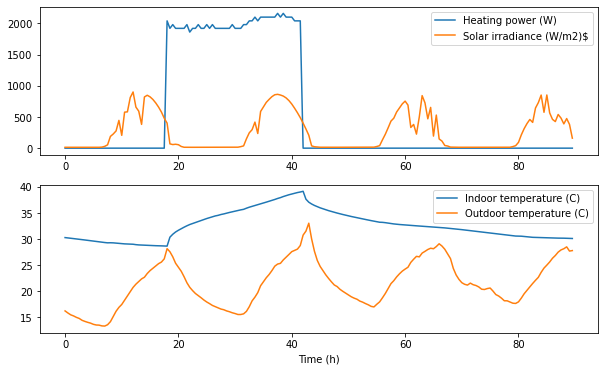

In [4]:
plt.figure(figsize=(10,6))

ax1 = plt.subplot(211)
plt.plot(df['Time']/3600, df['P_hea'], label='Heating power (W)')
plt.plot(df['Time']/3600, df['I_sol'], label='Solar irradiance (W/m2)$')
plt.legend()
#plt.setp(ax1.get_xticklabels(), fontsize=6)

# temperatures
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(df['Time']/3600, df['T_int'], label='Indoor temperature (C)')
plt.plot(df['Time']/3600, df['T_ext'], label='Outdoor temperature (C)')
plt.xlabel('Time (h)')
plt.legend()

plt.show()

The solar irradiance seems to have little impact on the indoor temperature, but we will keep it in the model nevertheless.

### First run of the 2R2C model

Since we will need to initialise the model calibration somewhere, it is useful to try the model with some arbitrary parameter values first.

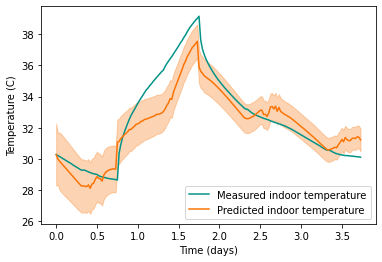

In [5]:
# Arrays containing time coordinates, inputs of the model and observed output
t = df['Time'].values
u = df[['T_ext', 'P_hea', 'I_sol']].values
y = df['T_int'].values

# Model specification
model = tite(Ri=1e-3, Re=1e-2, Ci=1e6, Ce=2e7, Ai=1, Ae=1, qi=1e-3, qe=1e-3, r=1e-2)
x_0 = [y[0], 30]

# Model prediction, without Kalman update
x_avg, x_var = model.prediction(x_0, t, u, y=None, update=False)

# Plotting the measured indoor temperature versus this prediction
# The prediction comes with 95% confidence intervals
t_ = df['Time']/24/3600
teal = '#029386'
orange = '#F97306'

plt.figure()
plt.plot(t_, y, label='Measured indoor temperature', color=teal)
plt.plot(t_, x_avg, label='Predicted indoor temperature', color=orange)
plt.fill_between(t_, x_avg-2*x_var**0.5, x_avg+2*x_var**0.5, alpha=0.3, color=orange)
plt.xlabel('Time (days)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

The agreement between model predictions and measurements is pretty bad, but at least we have a reasonable initial state for the parameters.

## Inference

### Model fitting

We now need to find the parameters that will offer the best fit between predictions of the 2R2C model and indoor temperature measurements. We will simply use the `curve_fit` method from scipy for now.

In order to facilitate convergence, an initial parameter value is first defined. Then, the optimiser will act on an evaluation function that receives normalised versions of each parameter, and scales them with this initial array. Some parameters are log-transformed in order to allow the search over larger scales.

In [6]:
# Initial parameter vector {Re, Ri, Ce, Ci, Ae, Ai, log_qe, log_qi, log_r, xe(0)}
theta_init = np.array([1e-3, 1e-2, 1e6, 2e7, 1, 1, -3, -3, -1, 30])
# Some parameters are log-transformed
log_transf = [False, False, False, False, False, False, True, True, True, False]

def transform(params):
    """
    arguments are the normalised value of all parameters
    theta is their physical value"""
    
    theta = params * theta_init
    theta[log_transf] = 10**theta[log_transf]
    
    return theta


# Definition of an evaluation function that takes "normalized" values or each parameter
def evaluation(df, nRi, nRe, nCi, nCe, nAi, nAe, nqi, nqe, nr, nxe0):
    
    params = np.array((nRi, nRe, nCi, nCe, nAi, nAe, nqi, nqe, nr, nxe0))
    # Reading the dataframe given as argument
    t = df['Time'].values
    u = df[['T_ext', 'P_hea', 'I_sol']].values
    y = df['T_int'].values
    
    # Transforming parameters from normalised to physical values
    Ri, Re, Ci, Ce, Ai, Ae, qi, qe, r, xe_0 = transform(params)
    
    # Model specification and initial condition
    model = tite(Ri, Re, Ci, Ce, Ai, Ae, qi, qe, r)
    x_0 = [y[0], xe_0]

    # Model prediction, without Kalman update
    X, S, L = model.prediction(x_0, t, u, y, update=True)
    
    # We only need the mean states for the curve_fit method
    return X

We now have everything we need to start the curve fitting algorithm, and save the results into a dataframe.

In [7]:
from scipy.optimize import curve_fit

# Curve fitting happens here. popt and pcov are the mean and covariance of parameter estimates
popt, pcov = curve_fit(evaluation,
                       xdata = df,
                       ydata = df['T_int'],
                       p0 = np.array(10*[1]),
                       method='lm')

res = pd.DataFrame(index=['Ri', 'Re', 'Ci', 'Ce', 'Ai', 'Ae', 'qi', 'qe', 'r', 'xe_0'])
res['theta_avg'] = transform(popt)
res['theta_std'] = transform(np.diag(pcov)**0.5)

print(res)

         theta_avg      theta_std
Ri    2.799371e-03   1.265692e-04
Re    1.683076e-02   1.283084e-03
Ci    3.772805e+06   1.524244e+05
Ce    1.469404e+07   8.578987e+05
Ai    1.557982e-01   4.597510e-02
Ae   -4.050937e-02   1.257605e-01
qi    8.220094e-08   0.000000e+00
qe    1.192036e-04  1.462550e-198
r     3.899127e-01  1.468587e-198
xe_0  2.992527e+01   5.622544e-01


The estimated parameters seem consistent with the range that we initially assumed. Notice that `Ae`, the solar gain coefficient on the envelope capacity, has an average value lower than its standard deviation: this parameter is likely not influential on the outcome.

### Diagnostics and residuals analysis

In order to evaluate the agreement between the fitted model and the data, let us first simply view the model output in prediction mode (without Kalman update at every time step).

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


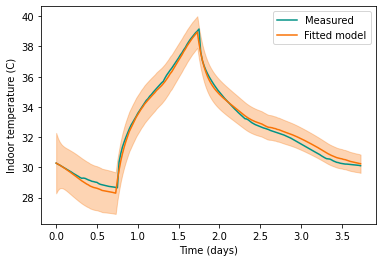

In [8]:
# Model specification
theta=res['theta_avg']
model_opt = tite(theta['Ri'], theta['Re'], theta['Ci'], theta['Ce'],
                 theta['Ai'], theta['Ae'], theta['qi'], theta['qe'], theta['r'])
x_0_opt = [y[0], theta['xe_0']]

# Prediction without Kalman update, to be compared with the data
x_avg, x_var = model_opt.prediction(x_0_opt, t, u, y=None, update=False)

plt.figure(figsize=(6,4))
plt.plot(t_, y, '-k', linewidth=1.5, label='Measured', color=teal)
plt.plot(t_, x_avg, linewidth=1.5, label='Fitted model', color=orange)
plt.fill_between(t_, x_avg-2*x_var**0.5, x_avg+2*x_var**0.5, color=orange, alpha=0.3)
plt.xlabel('Time (days)')
plt.ylabel('Indoor temperature (C)')
plt.legend()
plt.show()

The model fits the data well. The 95% confidence intervals are relatively narrow, indicating a good confidence in the prediction.

Another important criterion on which to judge the fitted model is the autocorrelation function (ACF) of the one-step ahead prediction residuals. In order to view these residuals, the prediction function should be run with the Kalman updating switched on, so that the states it returns are one-step ahead predictions only.

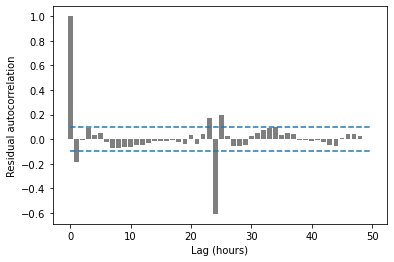

In [9]:
X, S, L = model_opt.prediction(x_0_opt, t, u, y, update=True)

# eps_ are the one-step ahead prediction residuals
eps_ = y - X
# Let's only take every other value, so that we have time lags of one hour.
eps_ = eps_[::2]

# Correlation function of two time series. Can be used for the autocorrelation of a single time series
def crosscorrelation(x, u):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    x = x-x.mean()
    u = u-u.mean()
    r = np.correlate(x, u, mode = 'full')[-n:]
    return r/(x.std()*u.std()*(np.arange(n, 0, -1)))

# Autocorrelation of the residuals (only keeping the first 50 lags)
ACF = crosscorrelation(eps_, eps_)[0:50]
lags = np.linspace(0,49,50)

plt.figure(figsize=(6,4))
plt.bar(lags, ACF, color='k', alpha=0.5)
plt.hlines([-0.1, 0.1], 0, 50, linestyles='dashed')
plt.xlabel('Lag (hours)')
plt.ylabel('Residual autocorrelation')
plt.show()

The residuals are low, except from one important peak at 24h lag. This suggests that an important influence occuring with a period of 24 hours has been insufficiently accounted for by the model.